<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Idea" data-toc-modified-id="Idea-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Idea</a></span><ul class="toc-item"><li><span><a href="#Inverse-Model" data-toc-modified-id="Inverse-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inverse Model</a></span></li></ul></li><li><span><a href="#The-game" data-toc-modified-id="The-game-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The game</a></span><ul class="toc-item"><li><span><a href="#The-environment" data-toc-modified-id="The-environment-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The environment</a></span></li><li><span><a href="#Figures" data-toc-modified-id="Figures-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Figures</a></span></li></ul></li><li><span><a href="#Estamos-corretamente-sampleando-da-distribuição" data-toc-modified-id="Estamos-corretamente-sampleando-da-distribuição-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Estamos corretamente sampleando da distribuição</a></span></li><li><span><a href="#Model-inversion" data-toc-modified-id="Model-inversion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model inversion</a></span><ul class="toc-item"><li><span><a href="#Grid" data-toc-modified-id="Grid-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Grid</a></span><ul class="toc-item"><li><span><a href="#Simulation" data-toc-modified-id="Simulation-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Simulation</a></span></li></ul></li><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Gradient Descent</a></span><ul class="toc-item"><li><span><a href="#Like" data-toc-modified-id="Like-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Like</a></span></li><li><span><a href="#Post" data-toc-modified-id="Post-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Post</a></span></li></ul></li></ul></li></ul></div>

# Idea

## Inverse Model

Bayesian rat. 
- Parameters
    - Learning Rate
    - Weber Fixed
    - Discounting
    

# The game

## The environment

In [1]:
import os
os.chdir('../../')

In [2]:
from spikelearn.visuals.visuals import singleRatBehaviorPlot
from spikelearn.tools.changepoint import reyes_cp
from spikelearn.data import io, select, SHORTCUTS

In [3]:
from itertools import count, product
import scipy.stats as st
import numpy as np
import pandas as pd
import time
import gc
# from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [5]:
sns.set_style('darkgrid')
plt.style.use('dark_background')
mpl.rc("figure", figsize=(10,6))
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.facecolor'] = (1,1,1,0)
mpl.rcParams['figure.facecolor'] = (1,1,1,0)
sns.set_palette('deep', color_codes=True)

In [6]:
import torch

- TODO 
    - Ajustar distribuições para que fiquem todas .sum()\*dt = 1 (normalizar) DONE
    - Testar discounting na escolha da ação
    - Verificar motivo dos picos distantes
    - Testar exponencial
        - No update -> ao invés do *reward
        - Na resposta 
        - ( somando )
        

- Futuro
    - Pegar prior do autoshape
    - Muscimol & discounting

In [7]:
class BayesianRat():
    """
    
    Attributes
    ----------
    
    model_logL
    """
    def __init__(self, learning_rate=.01, discounting=0, weber_ratio=.15, 
                    likelihood_dist='normal', range=(0,6), dt=1e-3, 
                    prior='lognormal' , responses=None, rule='like',
                    remember = True):
        
        self.weber_ratio = weber_ratio
        self.discounting = discounting
        self.learning_rate = learning_rate
        self.update_rule = rule
        self.dt = dt
        
        
        self.sup = np.arange(range[0], range[1], dt)
        self.prior_ = self._make_prior(prior)
        self.cdf_ = self.prior_.cumsum()
        if remember:
            self.prior_history = [self.prior_]
            self.likely_history = []
        self.has_memory = remember
        
        self.likelihood_dist_ = self._make_lh(prior)

        self.last_response_ = None
        self.responses = list(responses) if responses is not None else None
        
        self.is_tired_ = False
        
        # Stores the likelihood of actions taken given probabilities
        self.model_logL_ = 0
    
    # Meta function
    def _update_model_likelihood(self):
        move_probability = self.prior_[np.abs(self.sup - self.last_response_).argmin()]
        self.model_logL_ += np.log(move_probability)
    
    # Initialization functions
    def _make_prior(self, prior):
        if prior == 'lognormal':
            return st.lognorm(scale=1, s=1).pdf(self.sup)*self.dt
        elif isinstance(prior, np.array):
            assert len(prior) == len(self.sup)
            assert prior.sum()== 1/dt
            return prior
    
    def _make_lh(self, likelihood_dist):
        if likelihood_dist == 'lognormal':
            return lambda t: st.lognorm(scale=t, s=self.weber_ratio).pdf(self.sup)
        elif likelihood_dist == 'normal':
            return lambda t: st.norm(loc=t, scale=self.weber_ratio*t).pdf(self.sup)
    
    # Internal functions
    def _perceived_time(self, time):
        lkl = self.likelihood_dist_(time)
        return lkl/lkl.sum()
            
    def _update_prior(self, reward_value):
        likely_time = self._perceived_time(self.last_response_)
        
        
        if self.update_rule == 'like':
            update = likely_time
        elif self.update_rule == 'post':
            update = self.prior_ * likely_time
            update /= update.sum()
        
        lr = self.learning_rate * reward_value
        
        self.prior_ = (self.prior_ + update*lr)/(1+lr)
        self.prior_ /= self.prior_.sum()
        self.cdf_ = self.prior_.cumsum()
        
        if self.has_memory: 
            self.likely_history.append(likely_time)
            self.prior_history.append(self.prior_)
    
    def _sample_action(self):
        return self.sup[np.abs(self.cdf_ - np.random.rand()).argmin()]

    def _act_based_on_data(self):
        if len(self.responses) == 1: # Last response
            self.is_tired_ = True
        return self.responses.pop(0)
        
    # Behavior
    def act(self):
        if self.responses is not None:
            self.last_response_ = self._act_based_on_data()
        else:
            self.last_response_ = self._sample_action()
        
        self._update_model_likelihood()
        return self.last_response_

        
    def get_reward(self, reward):
        if reward:
            self._update_prior(np.exp(- self.discounting * self.last_response_))
       

In [8]:
class DRRD():
    """
    
    The Rat instance input in the play function must implement:
    - act() returning a float
    - get_reward()
    - is_tired_ , a boolean attribute.
    """
    def __init__(self, criterion, remember=True):
        # Time in seconds
        self.criterion = criterion
        if remember:
            self.history = pd.DataFrame(columns=['action', 'reward', 'criterion'])
        self.has_memory = remember
        
    def _reward(self, time):
        if time > self.criterion:
            return True
        else:
            return False
        
    def _store(self, action, reward):
        trial_data = pd.DataFrame({'action': action,
                                   'reward': reward,
                                   'criterion': self.criterion},
                                    index = pd.Index([self.trial], name='trial'))
        self.history = self.history.append(trial_data)
        
    def _reward_and_remember(self, action, rat):
        reward = self._reward(action)
        rat.get_reward(reward)
        
        if self.has_memory: self._store(action, reward)
        
        
    def play(self, rat, max_rounds=None):
        if max_rounds is None:
            playtime = count()
        else:
            playtime = range(max_rounds)
            
        for self.trial in playtime:
            action = rat.act()
            self._reward_and_remember(action, rat)
            if rat.is_tired_: break
                

class BurningRat():
    """
    
    Attributes
    ---------
    model_logL
    
    """
    def __init__(self, learning_rate=.01, discounting=0, weber_ratio=.15, 
                    likelihood_dist='normal', range=(0,6), dt=1e-3, 
                    prior='lognormal' , responses=None, rule='like',
                    remember = True, **kwargs):
        
        self.weber_ratio = torch.Tensor([weber_ratio])
        self.discounting = torch.Tensor([discounting])
        self.discounting.requires_grad = True
        self.learning_rate = torch.Tensor([learning_rate])
        self.learning_rate.requires_grad = True
        self.update_rule = rule
        self.dt = dt
        
        
        self.sup = torch.arange(range[0], range[1], dt)
        self.prior_ = self._make_prior(prior)
        self.cdf_ = self.prior_.cumsum(0)*self.dt
        self.likelihood_dist_ = self._make_lh(prior)
               
        
        
        self.responses = list(responses) if responses is not None else None
        
        self.last_response_ = None
        self.is_tired_ = False
        
        # Stores the likelihood of actions taken given probabilities
        self.model_logL_ = 0
        # Stores priors and likelihood across actions
        if remember:
            self.prior_history = [self.prior_]
            self.likely_history = []
        self.has_memory = remember
    
    # Meta function
    def _update_model_likelihood(self):
        move_probability = self.prior_[torch.abs(self.sup - self.last_response_).argmin()]*self.dt
        self.model_logL_ += torch.log(move_probability)
    
    # Initialization functions
    def _make_prior(self, prior):
        if prior == 'lognormal':
            return torch.Tensor(st.lognorm(scale=1, s=1).pdf(self.sup))
        elif isinstance(prior, torch.Tensor):
            assert len(prior) == len(self.sup)
            assert prior.sum()*self.dt == 1
            return prior
    
    def _make_lh(self, likelihood_dist):
        if likelihood_dist == 'lognormal':
            return lambda t: torch.Tensor(st.lognorm(scale=t, s=self.weber_ratio).pdf(self.sup))
        elif likelihood_dist == 'normal':
            return lambda t: torch.Tensor(st.norm(loc=t, scale=self.weber_ratio*t).pdf(self.sup))
    
    # Internal functions
    def _perceived_time(self, time):
        lkl = self.likelihood_dist_(time)
        return lkl
            
    def _update_prior(self, reward_value):
        likely_time = self._perceived_time(self.last_response_)
        
        
        if self.update_rule == 'like':
            update = likely_time
        elif self.update_rule == 'post':
            update = self.prior_ * likely_time
            update /= (update.sum()*self.dt)
                    
        lr = self.learning_rate * reward_value
        self.prior_ = (self.prior_*(1-lr) + update*lr)
        self.prior_ /= self.dt*self.prior_.sum()
        self.cdf_ = self.prior_.cumsum(0)*self.dt
        
        if self.has_memory:
            self.likely_history.append(likely_time)
            self.prior_history.append(self.prior_)
    
    def _sample_action(self):
        return self.sup[torch.abs(self.cdf_ - torch.rand(1)).argmin()]

    def _act_based_on_data(self):
        if len(self.responses) == 1: # Last response
            self.is_tired_ = True
        return self.responses.pop(0)
        
    # Behavior
    def act(self):
        if self.responses is not None:
            self.last_response_ = self._act_based_on_data()
        else:
            self.last_response_ = self._sample_action()
        
        self._update_model_likelihood()
        return self.last_response_

        
    def get_reward(self, reward):
        if reward:
            discounted_reward = torch.exp(- self.discounting * self.last_response_)
            self._update_prior(discounted_reward)
       

---

In [157]:
burn = BurningRat(discounting=1.4, learning_rate=.04, dt=0.01, rule='post', range=(0,5))

In [158]:
task = DRRD(1.5)
%time task.play(burn, 1000)

CPU times: user 2.97 s, sys: 60 ms, total: 3.03 s
Wall time: 3.03 s


## Figures

In [155]:
def plot_bayes(task, bayes, N=40, k=10):
    plt.subplot(2,1,2)
    prior_n = task.history.reward.cumsum()
    trials_to_plot = prior_n < N*k
    plt.scatter(task.history.action[trials_to_plot],trials_to_plot[trials_to_plot].index, 
                    cmap='plasma', c=prior_n[trials_to_plot], s=20)
    plt.gca().grid()
    plt.xlim(bayes.sup[0],bayes.sup[-1])

    plt.subplot(2,1,1)
    c = sns.color_palette('plasma', N)
    for i in range(N):
        plt.plot(list(bayes.sup), list(bayes.prior_history[k*i]), color=c[i], alpha=.8)

    plt.xlim(bayes.sup[0],bayes.sup[-1])
    plt.gca().grid()

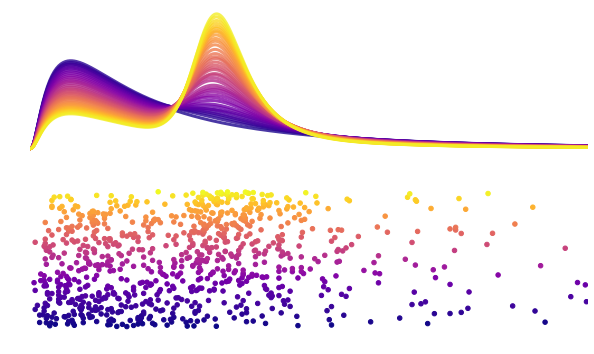

In [159]:
plot_bayes(task, burn, N=40, k=10)

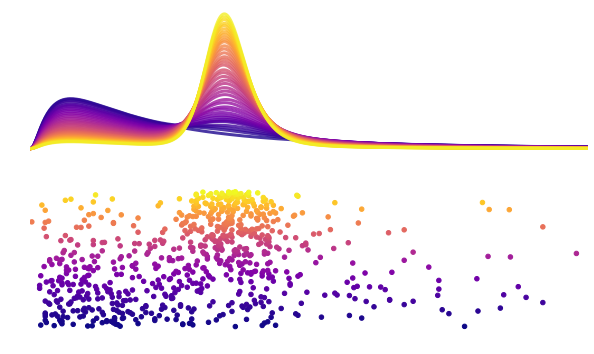

In [236]:
N, k = 40, 10

plt.subplot(2,1,2)
prior_n = task.history.reward.cumsum()
trials_to_plot = prior_n < N*k
plt.scatter(task.history.action[trials_to_plot],trials_to_plot[trials_to_plot].index, 
                cmap='plasma', c=prior_n[trials_to_plot], s=20)
plt.gca().grid()
plt.xlim(bayes.sup[0],bayes.sup[-1])

plt.subplot(2,1,1)
c = sns.color_palette('plasma', N)
for i in range(N):
    plt.plot(list(bayes.sup), list(bayes.prior_history[k*i]), color=c[i], alpha=.8)
    
plt.xlim(bayes.sup[0],bayes.sup[-1])
plt.gca().grid()

---

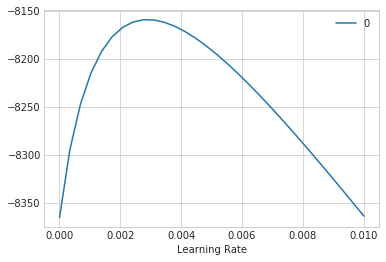

In [115]:
logL.transpose().plot()

---

# Estamos corretamente sampleando da distribuição

In [98]:
prior = st.lognorm(scale=4, s=.15).pdf(sup)

In [26]:
cdf = prior.cumsum().reshape(-1,1)
cdf /=cdf.max()

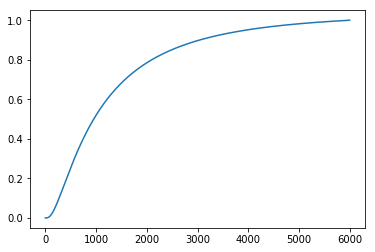

In [27]:
plt.plot(cdf)

In [44]:
N = 1000
s = sup[np.abs(cdf-np.random.random(size=(1,N))).argmin(axis=0)]

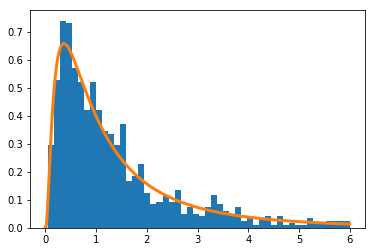

In [45]:
plt.hist(s,50, density=True);
plt.plot(sup, prior, linewidth=3)

In [47]:
s.mean()

1.3459909999999999

- Taxa média
- Bracketing

---

# Model inversion

In [102]:
# def invert_model(game, model, responses, param_dict, pbar=True):
#     param_names = list(param_dict.keys())
#     results = pd.DataFrame(columns=param_names+['loglikelihood'])
#     if pbar:
#         niter = len(list(product(*tuple(param_dict.values()))))
#         param_combs = tqdm(product(*tuple(param_dict.values())), total=niter)
#     else:
#         param_combs = product(*tuple(param_dict.values()))
#     for params in param_combs:
#         instance_params = dict(zip(param_names, params))
#         instance = model(responses=responses,**instance_params, remember=False)
        
#         cronometer = time.time()
#         game.play(instance)
        
        
#         instance_params.update({'loglikelihood':instance.model_logL_,
#                                 'time': time.time()-cronometer } )
#         results = results.append(pd.DataFrame(instance_params, index=[0]))
#         gc.collect()
#     return results
from contextlib import closing
from multiprocessing import Pool
from functools import partial

def invert_model(game, model, responses, param_dict, pbar=False, n_jobs=30):
    param_names = list(param_dict.keys())
    if pbar:
        niter = len(list(product(*tuple(param_dict.values()))))
        param_combs = tqdm(product(*tuple(param_dict.values())), total=niter)
    else:
        param_combs = product(*tuple(param_dict.values()))
        
    param_test = partial(test_params, param_names=param_names, 
                         model=model, responses=responses, game=game)
    print(param_names)
    with closing(Pool(n_jobs)) as p:
        results = pd.concat(p.map(param_test, param_combs))
    return results
 
def test_params(params, param_names, model, responses, game):
    instance_params = dict(zip(param_names, params))
    instance = model(responses=responses,**instance_params, remember=False)

    cronometer = time.time()
    game.play(instance)
    instance_params.update({'loglikelihood':instance.model_logL_,
                            'time': time.time()-cronometer } )
    return pd.DataFrame(instance_params, index=[0])
    
def uninformed_search(responses, task, rule):
    """
    Uninformed search will consist of 3 parts:
    Learning rate search
    
    1. Order of magnitude search
        1.1. 1e-o 1e5
        1.2. best/10 to best*10
        
    2. Linear search
        - Best fit
    
    Discount search
    3. Grid
        - lr to lr*10
        - Discount 0 to 3 (linear)
    """
    # Uninformed search
    # Phase 1.1
    lrates = np.logspace(-5, 5, 10)
    param_dict = {'learning_rate' : lrates, 'rule':[rule]}
    phase11 = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index('learning_rate')
    best_lr = phase11.loglikelihood.idxmax()
    
    
    # Phase 1.2
    lrates = np.logspace(np.log10(best_lr)-1, np.log10(best_lr)+1, 10)
    param_dict = {'learning_rate' : lrates, 'rule':[rule]}
    phase12 = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index('learning_rate')
    best_lr = phase12.loglikelihood.idxmax()
    
    # Phase 2
    lrates = np.linspace(best_lr/10, best_lr*10, 50)
    param_dict = {'learning_rate' : lrates, 'rule':[rule]}
    res_lr = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index('learning_rate')
    best_lr = res_lr.loglikelihood.idxmax()
    
    # Phase 3
    lrates, discounts = np.linspace(best_lr, best_lr*10, 30), np.linspace(0, 3, 30)
    param_dict = {'learning_rate' : lrates, 'discounting':discounts, 'rule':[rule]}
    res_both = invert_model(task, BayesianRat, 
                   responses = responses, 
                   param_dict = param_dict, pbar=False).set_index(['learning_rate', 'discounting'])

    return phase11, phase12, res_lr, res_both


def best_fit(responses, task):
    _, _, lr_post, both_post = uninformed_search(responses, task, 'post')
    _, _, lr_like, both_like = uninformed_search(responses, task, 'like') 
    return pd.concat((lr_post, lr_like)), pd.concat((both_post, both_like))

In [103]:
def logL_descent(responses, task, params, grad_rate=.01, n_iter=10, rule='post', clip=True):
    results = pd.DataFrame()
    for i in range(1, n_iter):
        rat = BurningRat(responses=responses, **params, remember=False, rule=rule)
        task.play(rat)
        params['logL'] = rat.model_logL_.detach().numpy()
        results = results.append(pd.DataFrame(params, index=[i]))
        
        rat.model_logL_.backward()
        if clip:
            params['discounting'] += np.clip(rat.discounting.grad, -3e3, 3e3) * grad_rate
            params['learning_rate'] += np.clip(rat.learning_rate.grad, -3e3, 3e3) * grad_rate
        else:
            params['discounting'] += rat.discounting.grad * grad_rate
            params['learning_rate'] += rat.learning_rate.grad * grad_rate
        
    return results

## Grid

In [104]:
responses = select(io.load(label, 'behav_stats'), is_tired=False).duration.values
task = DRRD(1.5, False)
%time lr, rr = best_fit(responses, task)

['learning_rate', 'rule']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log


['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
CPU times: user 3 s, sys: 23.2 s, total: 26.2 s
Wall time: 2min


In [153]:
rr.loglikelihood.idxmax()

(0.01727155890785182, 0.6206896551724138)

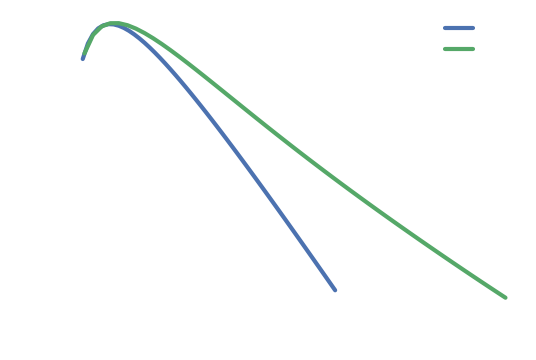

In [144]:
plt.figure(figsize=(6,4), dpi=100)
lr[lr.rule=='post'].loglikelihood.plot(label = 'post')
lr[lr.rule=='like'].loglikelihood.plot(label = 'like')
plt.legend()

(0, 0.01)

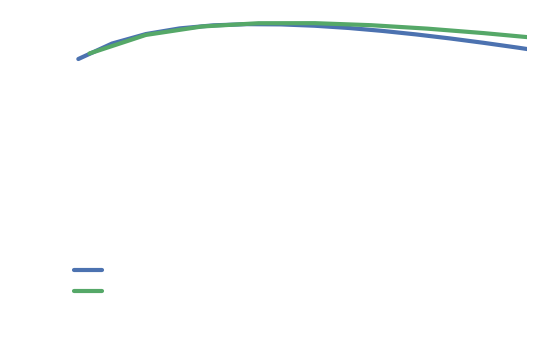

In [163]:
plt.figure(figsize=(6,4), dpi=100)
lr[lr.rule=='post'].loglikelihood.plot(label = 'post')
lr[lr.rule=='like'].loglikelihood.plot(label = 'like')
plt.legend()

In [185]:
params = ['learning_rate', 'discounting','rule']
dict(zip(params, rr.reset_index().set_index(params).loglikelihood.idxmax()))

{'learning_rate': 0.01727155890785182,
 'discounting': 0.6206896551724138,
 'rule': 'like'}

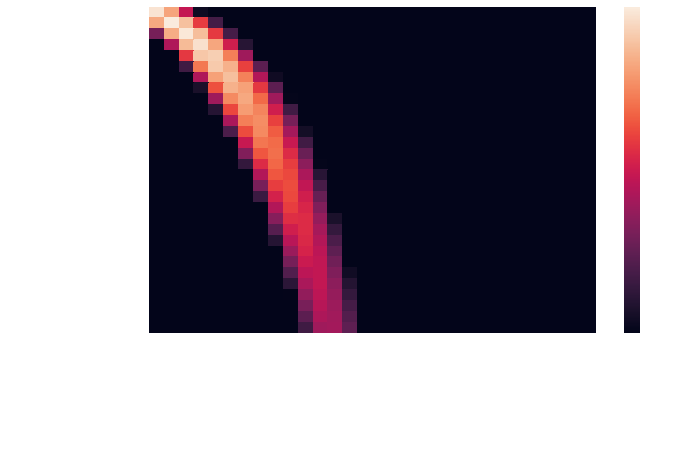

In [150]:
sns.heatmap(rr[rr.rule=='post'].loglikelihood.unstack('discounting'), vmin=-4900)

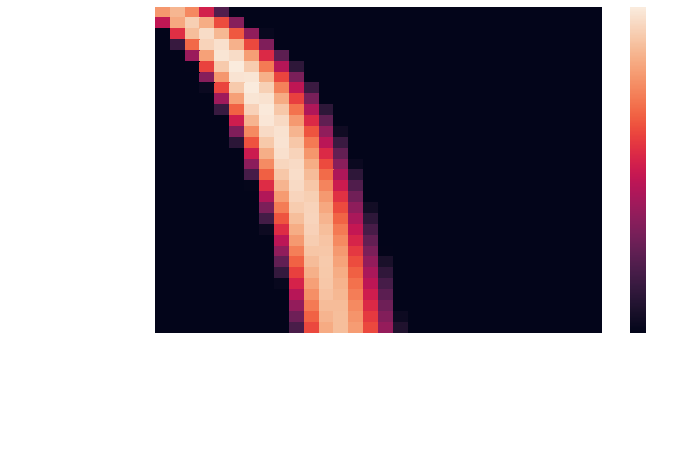

In [149]:
sns.heatmap(rr[rr.rule=='like'].loglikelihood.unstack('discounting'), vmin=-4900)

### Simulation

In [161]:
(27155890785182, 6896551724138)
task = DRRD(1.5)
bayes = BurningRat(0.017, 0.620)
task.play(bayes, 1000)

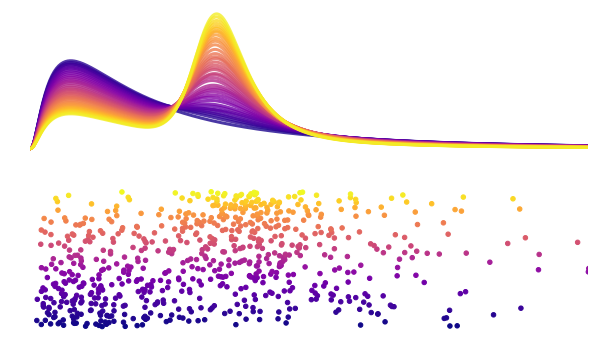

In [162]:
plot_bayes(task, burn, N=40, k=10)

In [186]:
import pickle

In [187]:

for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    responses = select(io.load(label, 'behav_stats'), is_tired=False).duration.values
    task = DRRD(1.5, False)
    %time lr, rr = best_fit(responses, task)
    pickle.dump(rr, open('data/results/{}_bayes_simulation.pkl'.format(label),'wb'))

['learning_rate', 'rule']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log


['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
CPU times: user 2.99 s, sys: 23 s, total: 26 s
Wall time: 2min 50s
['learning_rate', 'rule']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log


['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
CPU times: user 3 s, sys: 23.1 s, total: 26.1 s
Wall time: 1min 51s
['learning_rate', 'rule']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log


['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
CPU times: user 2.98 s, sys: 23.4 s, total: 26.4 s
Wall time: 1min 53s
['learning_rate', 'rule']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log


['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'rule']
['learning_rate', 'discounting', 'rule']
CPU times: user 3.18 s, sys: 23.3 s, total: 26.5 s
Wall time: 3min 26s


In [190]:
task.history.action.values[:len(responses)].shape

(1200,)

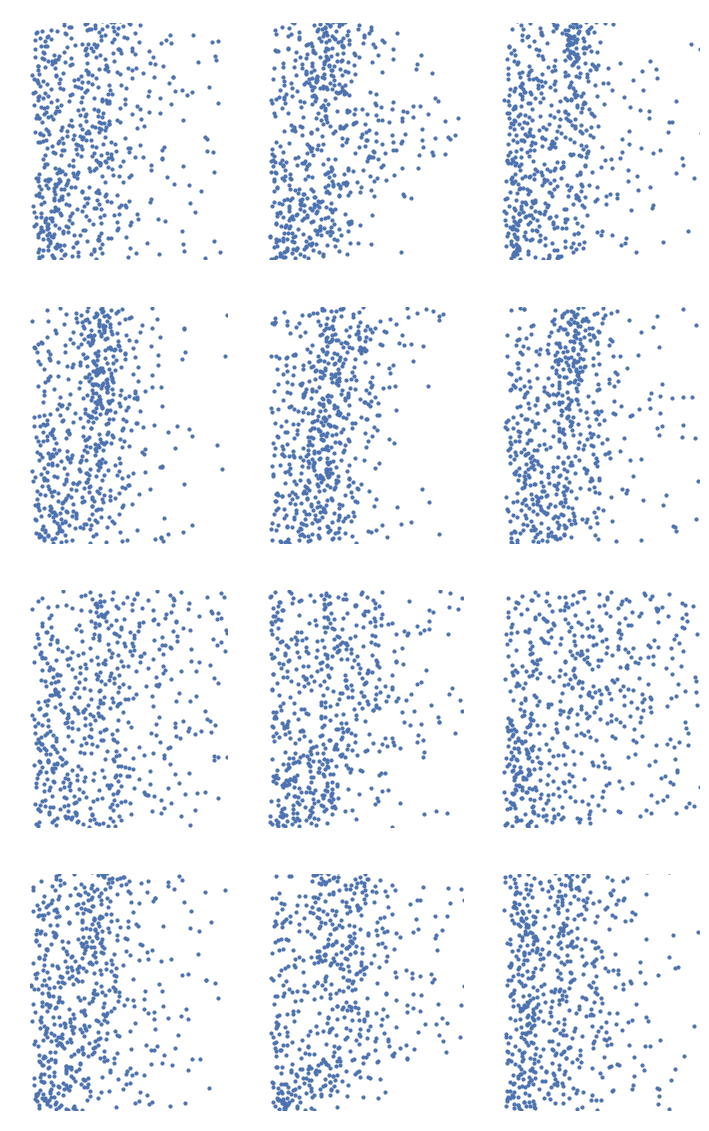

In [196]:
fig, ax = plt.subplots(4,3,figsize=(12,20), sharex=True, sharey=True)
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    responses = select(io.load(label, 'behav_stats'), is_tired=False).duration.values
    rr = pickle.load(open('data/results/{}_bayes_simulation.pkl'.format(label),'rb'))
    params = ['learning_rate', 'discounting','rule']
    params = dict(zip(params, rr.reset_index().set_index(params).loglikelihood.idxmax()))

    task = DRRD(1.5)
    bayes = BurningRat(**params)
    task.play(bayes, len(responses)+1)
    ax[i,0].scatter(task.history.action.values[:min(1000,len(responses))],trials_to_plot.index.values[:min(1000,len(responses))], s=10)
    ax[i,0].set_title('{} simulation'.format(label))
    task = DRRD(1.5)
    bayes = BurningRat(**params)
    task.play(bayes, len(responses)+1)
    ax[i,2].scatter(task.history.action.values[:min(1000,len(responses))],trials_to_plot.index.values[:min(1000,len(responses))], s=10)
    ax[i,2].set_title('{} simulation'.format(label))
    ax[i,1].scatter(responses[:1000], np.arange(min(1000,len(responses))), s=10)
    ax[i,1].set_title('{} real responses'.format(label))
    ax[0,1].set_xlim(0,5)
    ax[0,1].set_ylim(0,600)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'c', 's'
  s)


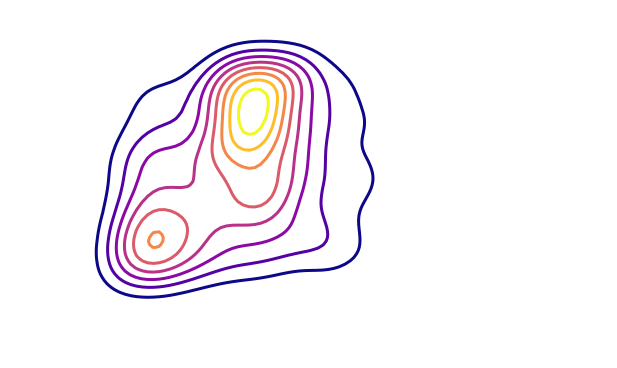

In [168]:
sns.kdeplot(task.history.action[trials_to_plot],trials_to_plot[trials_to_plot].index, 
                    cmap='plasma', c=prior_n[trials_to_plot], s=15)

ValueError: c of shape (896,) not acceptable as a color sequence for x with size 600, y with size 600

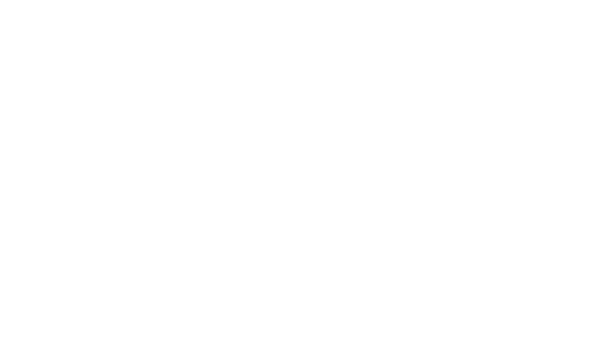

In [169]:
plt.scatter(responses, np.arange(len(responses)),
           cmap='plasma', c=prior_n[trials_to_plot], s=15)

## Gradient Descent 

### Like

In [93]:
label = 'DRRD 8'
responses = select(io.load(label, 'behav_stats'), is_tired=False).duration.values
task = DRRD(1.5, False)
res= []
for i in range(10):
    p0 = {'discounting': np.random.normal(2), 'learning_rate':np.random.rand()/10}
    print(p0)
    %time local = logL_descent(responses, task, p0, 1e-4, n_iter=10, rule='like')
    local['init'] = i
    res.append(local)

{'discounting': 0.7721203970001287, 'learning_rate': 0.09011385092288005}
CPU times: user 21.4 s, sys: 363 ms, total: 21.7 s
Wall time: 7.59 s
{'discounting': 0.7170740096432096, 'learning_rate': 0.04465623330451794}
CPU times: user 23.9 s, sys: 228 ms, total: 24.1 s
Wall time: 7.13 s
{'discounting': 0.6916043534525838, 'learning_rate': 0.06418474687784873}
CPU times: user 24 s, sys: 260 ms, total: 24.2 s
Wall time: 7.12 s
{'discounting': 0.38533598223134535, 'learning_rate': 0.0006577609314499467}
CPU times: user 22.8 s, sys: 217 ms, total: 23 s
Wall time: 6.95 s
{'discounting': 2.8482660428488877, 'learning_rate': 0.03104862321635733}
CPU times: user 23.6 s, sys: 225 ms, total: 23.8 s
Wall time: 7 s
{'discounting': 3.1317734751816033, 'learning_rate': 0.029537354781715465}
CPU times: user 25.5 s, sys: 438 ms, total: 26 s
Wall time: 9.01 s
{'discounting': 2.269044336133138, 'learning_rate': 0.05832738412704129}
CPU times: user 24.3 s, sys: 153 ms, total: 24.4 s
Wall time: 7.58 s
{'dis

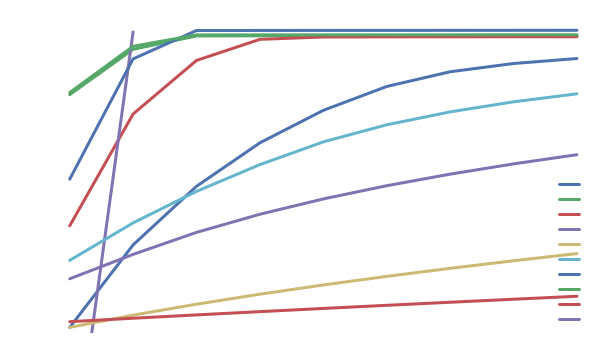

In [84]:
for r in res:
    r.logL.plot(label=r.init.values[0])
plt.ylim(-5000)
plt.legend()

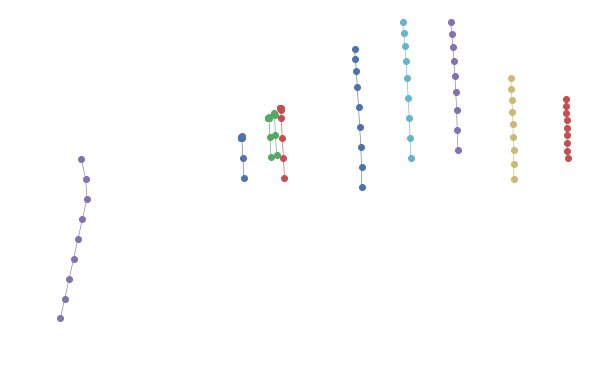

In [91]:
[r.set_index('discounting').learning_rate.plot(linewidth=.6, marker='o') for r in res]
# plt.ylim(-1,1); plt.xlim(1.5,1.65)

### Post 

In [87]:
label = 'DRRD 8'
responses = select(io.load(label, 'behav_stats'), is_tired=False).duration.values
task = DRRD(1.5, False)
pos_res= []
for i in range(10):
    p0 = {'discounting': np.random.normal(2), 'learning_rate':np.random.rand()/10}
    print(p0)
    %time local = logL_descent(responses, task, p0, 1e-5, n_iter=20, rule='post')
    local['init'] = i
    pos_res.append(local)

{'discounting': 1.9631064946784107, 'learning_rate': 0.012207400741463181}
CPU times: user 1min 8s, sys: 446 ms, total: 1min 9s
Wall time: 16.4 s
{'discounting': 2.68016811323376, 'learning_rate': 0.0550454158469029}
CPU times: user 1min 11s, sys: 464 ms, total: 1min 12s
Wall time: 17 s
{'discounting': 1.606649209682942, 'learning_rate': 0.09738994743286687}
CPU times: user 1min 11s, sys: 512 ms, total: 1min 12s
Wall time: 17.1 s
{'discounting': 2.3832566664707273, 'learning_rate': 0.08122266375857069}
CPU times: user 1min 10s, sys: 435 ms, total: 1min 10s
Wall time: 16.4 s
{'discounting': 1.597985373673792, 'learning_rate': 0.0946001218530772}
CPU times: user 1min 10s, sys: 462 ms, total: 1min 10s
Wall time: 16.3 s
{'discounting': 1.0743640159368293, 'learning_rate': 0.04458458453047417}
CPU times: user 1min 11s, sys: 500 ms, total: 1min 11s
Wall time: 16.7 s
{'discounting': 2.5639962072620093, 'learning_rate': 0.0978655814813448}
CPU times: user 1min 12s, sys: 511 ms, total: 1min 13s

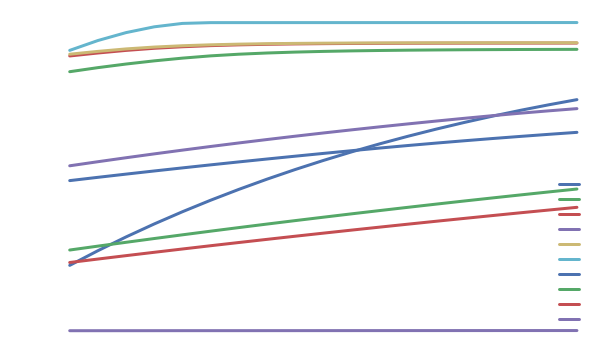

In [88]:
for r in pos_res:
    r.logL.plot(label=r.init.values[0])
plt.ylim(-5000)
plt.legend()

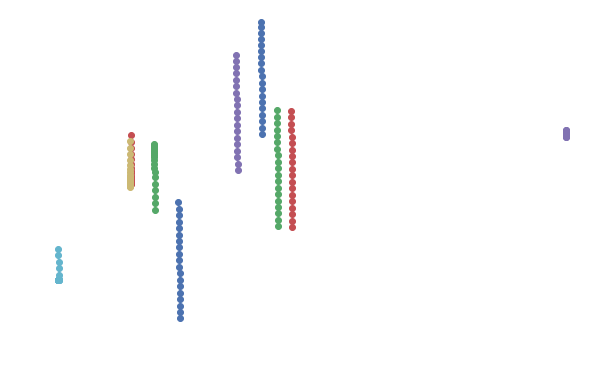

In [90]:
[r.set_index('discounting').learning_rate.plot(linewidth=.6, marker='o') for r in pos_res]
# plt.ylim(-1,1); plt.xlim(1.5,1.65)

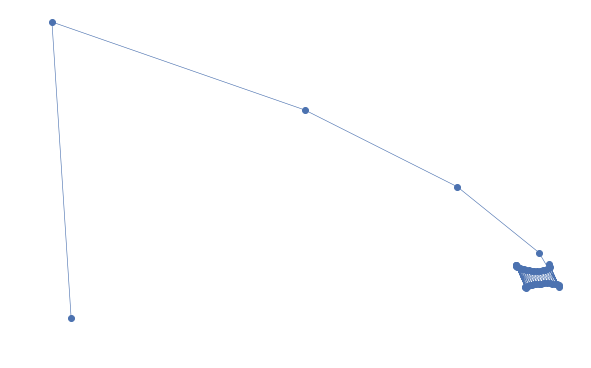

In [41]:
res.set_index('discounting').learning_rate.plot(linewidth=.6, marker='o')

(1.39, 1.42)

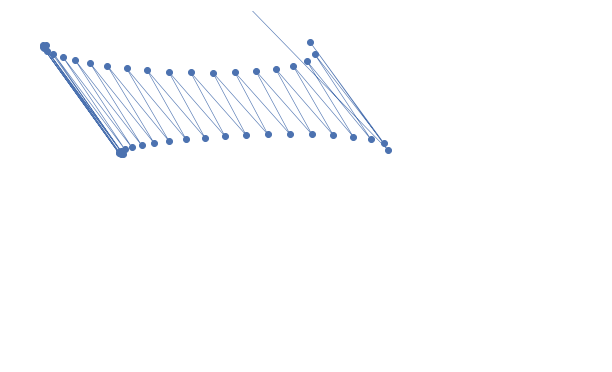

In [42]:
res.set_index('discounting').learning_rate.plot(linewidth=.6, marker='o')
plt.ylim(.0,.1); plt.xlim(1.39,1.42)

---

In [157]:
for label in SHORTCUTS['groups']['DRRD']:
    print( label )
    responses = select(io.load(label, 'behav_stats'), is_tired=False).duration.values
    task = DRRD(1.5, False)
    best_lr, best_both = best_fit(responses, task)
    if not os.path.exists('data/results/bayesian_learning'):
        os.makedirs('data/results/bayesian_learning')
    pickle.dump(best_lr, open('data/results/bayesian_learning/lr%s.pickle'%label, 'wb'))
    pickle.dump(best_both, open('data/results/bayesian_learning/both%s.pickle'%label, 'wb'))

KeyboardInterrupt: 

---

Anotações reunião 25/05

- Fazer z-score para cada neurônio

- Diferença no estriado no dia 2:
    - Atividade média da trial.